This demo requires the following packages:

```
conda install pytorch cudatoolkit=X.X  astra-toolbox matplotlib tqdm -c astra-toolbox/label/dev -c pytorch
pip install git+https://github.com/ahendriksen/tomosipo.git
```



<Figure size 432x288 with 0 Axes>

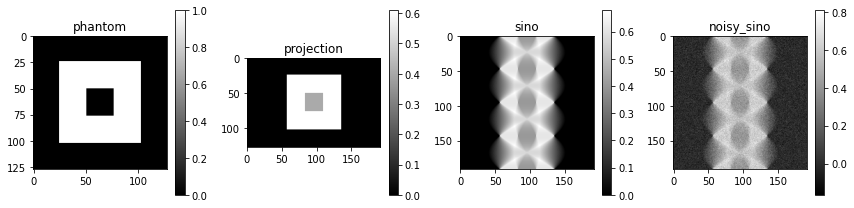

In [1]:
import torch 
import tomosipo as ts
from tomosipo.torch_support import (
    to_autograd,
)
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
plt.gray()

def plot_imgs(height=3, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        pcm = ax.imshow(v.detach().cpu().numpy().squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()

    
# Volume is the unit cube with N^3 voxels. 
# projection geometry is 1.5 units wide and 1 unit high.
# This geometry ensures that the operator norm of full_A is reasonable.
N = 128
full_vg = ts.volume(size=1, pos=0, shape=N)
full_pg = ts.parallel(angles=3 * N // 2, shape=(N, 3 * N // 2), size=(1, 1.5))
full_A = ts.operator(full_vg, full_pg)

phantom = ts.phantom.hollow_box(ts.data(full_vg)).data
phantom = torch.from_numpy(phantom)
sino = full_A(phantom)
noisy_sino = sino + sino.max() / 20 * torch.randn_like(sino)

plot_imgs(
    phantom=phantom[64],       # central axial slice
    projection=sino[:, 0, :],  # first projection image
    sino=sino[64, ...],        # sinogram of central slice
    noisy_sino=noisy_sino[64, ...], # noisy sinogram
)    

In [2]:
# The network defined below should be almost the same as the primal-dual network described in:

# Adler, J., & Öktem, Ozan, Learned Primal-Dual Reconstruction, IEEE Transactions on Medical Imaging, (), 1–1 (2018)
# http://dx.doi.org/10.1109/tmi.2018.2799231

# Intended differences are the use of ReLU instead of PReLU, and the lack of biases. 

# All other differences are unintentional.. 

class PrimalModule(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(6, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 5, kernel_size=3, padding=1, bias=False),
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class DualModule(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(7, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 5, kernel_size=3, padding=1, bias=False),
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class LearnedPD(nn.Module):
    def __init__(self, vg, pg, n_iters, do_pingpong=False):
        super().__init__()
        self.n_iters = n_iters
        self.vg = vg
        self.pg = pg
        self.do_pingpong = do_pingpong
        
        for i in range(n_iters):      
            # To ensure that the parameters of the primal and dual modules 
            # are correctly distributed during parallel training, we register
            # them as modules. 
            self.add_module(f"{i}_primal", PrimalModule())
            self.add_module(f"{i}_dual", DualModule())
                
    def forward(self, g):
        B, C, H, W = g.shape
        assert C == 1, "single channel support only for now"
        h = g.new_zeros(B, 5, H, W)
        f_primal = g.new_zeros(B, 5, *self.vg.shape[1:])
        
        def dual_step(g, h, f, module):
            x = torch.cat((h, f, g), dim=1)
            out = module(x)
            return h + out
        def primal_step(f, update, module):
            x = torch.cat((f, update), dim=1)
            out = module(x)
            return f + out
        
        ts_op = ts.operator(self.vg[:1], self.pg.to_vec()[:, :1, :])
        op = to_autograd(ts_op)
        opT = to_autograd(ts_op.T)
        def fp(x):
            if self.do_pingpong:
                x = x.cpu()
            return op(x).cuda()
        def bp(x):
            if self.do_pingpong:
                x = x.cpu()
            return opT(x).cuda()
        
        for i in range(self.n_iters):
            primal_module = getattr(self, f"{i}_primal")
            dual_module = getattr(self, f"{i}_dual")
            
            f_dual = fp(f_primal[:, :1])
            h = dual_step(g, h, f_dual, dual_module)
            update = bp(h[:, :1])
            f_primal = primal_step(f_primal, update, primal_module)
            
        return f_primal[:, 0:1]

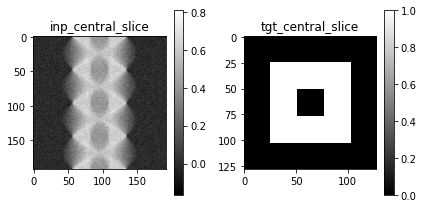

In [3]:
train_ds = torch.utils.data.TensorDataset(noisy_sino, phantom)

plot_imgs(
    inp_central_slice = train_ds[64][0],
    tgt_central_slice = train_ds[64][1], 
)

In [10]:
# To see how performance is impacted by moving data to and from the gpu before 
# ASTRA operations (pingpong), set `pingpong=True`
epochs = 50
batch_size = 4
learning_rate = 1e-4
parallel_gpu = False
pingpong = False

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False)

# In practice, parallel_gpu appears to be slower.. 
net = LearnedPD(full_vg, full_pg, 10, do_pingpong=True).cuda()
if parallel_gpu:
    net = nn.DataParallel(net).cuda()
    
training_loss = np.zeros(epochs * len(train_ds) // batch_size)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

i = 0
for epoch in range(epochs):
    for batch in tqdm(train_dl):
        inp, tgt = batch
        # Move to gpu and add channel dimension
        inp, tgt = inp.cuda()[:, None, ...], tgt.cuda()[:, None, ...]
        out = net(inp)
        loss = criterion(out, tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss[i] = loss.item()
        i += 1

100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


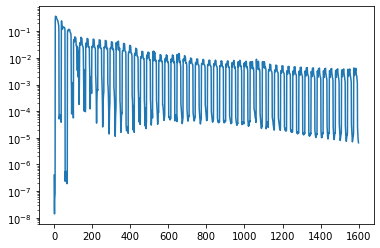

In [11]:
# The lack of shuffling in the training dataset makes visible the periodicity in the training loss. 
# The cube is more difficult to reconstruct than the background.
# Although shuffing likely improves training performance, this yields more interpretable plots :) 
plt.plot(training_loss)
plt.yscale('log')

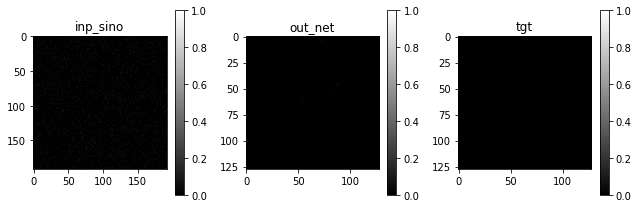

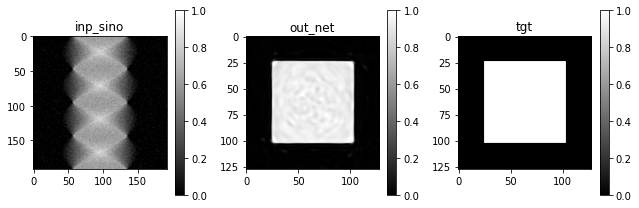

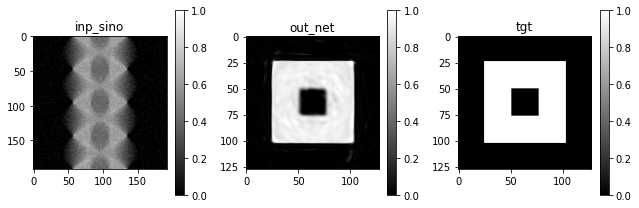

In [12]:
slice = 32

for slice in [0, 32, 64]:
    inp_sino = train_ds[slice][0].cuda()
    out_net = net(inp_sino[None, None, ...])
    tgt = train_ds[slice][1].cuda()
    plot_imgs(
        inp_sino = inp_sino,
        out_net = out_net,
        tgt = tgt,
        clim=(0, 1),
    )

For a good speed comparison, check out learned_pd_benchmark.py. 

To see how to efficiently implement multi-gpu training, check out learned_pd_lightning.py. 